In [1]:
%matplotlib inline

import matplotlib
# matplotlib.use('pgf')
# pgf_with_rc_fonts = {
#     "font.family": "serif",
#     "font.serif": [],                   # use latex default serif font
#     "font.sans-serif": ["DejaVu Sans"], # use a specific sans-serif font
#     "pgf.rcfonts" : False
# }
# matplotlib.rcParams.update(pgf_with_rc_fonts)

from matplotlib import rc
import matplotlib.pyplot as plt

import scipy.stats as st
import numpy as np
import json

import sys
sys.path.append("/home/joshua/Documents/Uni/Year4/dissertation/catkin_ws/src/linefollow_gazebo/scripts")

import helper as h
from CameraModel import Camera
from RoadModel import Road, NormalProbabilityDist
from Path import Path

plt.style.use('ggplot')
from matplotlib import rc

rc('text', usetex=True)
matplotlib.rcParams['axes.facecolor'] = 'white'
matplotlib.rcParams['axes.edgecolor'] = '0.4'
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False
matplotlib.rcParams['grid.color'] = "0.9"

plt.tight_layout(.5)


# Single Camera

All analysis here is conducted with a simpler objective function: maximizing ( expected improvement in location uncertainty).
    
This directly related to the kalman gain: as measurement noise -> 0, kalmain gain -> 1 and the measurement is taken as more as better truth estimator. If measurement noise is very large, kalman gain -> 0 and measurement is ignored. We obtain the best reduction in KF covariance by therefore maximizing the kalman gain, or minimizing measurement noise.
    
Therefore, the goal of maximizing expected localization uncertainty improvement is equivalent to minimizing expected measurement noise R_k. Across the pixel plane therefore, we can use the sum(prob of vehicle center being in pixel * measurement error at that pixel)

In [2]:
# will use the same probability distribution across all experiments
road_prob_dist = NormalProbabilityDist(two_stddev=0.4) # vehicles will 95% of time be +-0.4 meter of center of road
#
resolution = (300,300)

In [3]:
def get_predicted_error_radius(camera_height,
                               ground_distance, 
                               pixel_area,
                               sigma_pos=0.03/2.0,
                               sigma_orient_deg=0.5/2,
                               alg_error=4.0, # note: changed
                               verbose=False,
                               orientation_percent=0.9,
                               pos_percent=0.9,
                               alg_percent=0.9,
                               use_err_xy=True,
                               use_err_z=True,
                               use_err_orient=True,
                               use_err_pixel=True
                              ):
    # TODO this is wrong implementation! Doesn't matter though really as long as use is consistent
    # but really it should be -1*norm.ppf((1-percent)/2.0)
    # as it is is an underestimate

    stddevs_orientation = st.norm.ppf(orientation_percent)
    stddevs_position = st.norm.ppf(pos_percent)
    stddevs_alg = st.norm.ppf(alg_percent)
    
    
    # NOT invariant between pixels
    z_error = (ground_distance/camera_height)*stddevs_position*sigma_pos if use_err_z else 0
    
    # NOT invariant between pixels
    if use_err_orient:
        t = stddevs_orientation*np.deg2rad(sigma_orient_deg)
        alpha = np.arctan2(ground_distance, camera_height)
        beta = alpha + t
        if beta > np.pi/2: # causes tan to roll over into negatives...
            orientation_error = 9999999999
        else:
            orientation_error = np.tan(beta)*camera_height - ground_distance
    else:
        orientation_error = 0
    
    pixel_error = np.sqrt(2*pixel_area) if use_err_pixel else 0
    
#     print("Z error: {0}".format(z_error))
#     print("orien error: {0}".format(orientation_error))
#     print("pixel_error: {0}".format(pixel_error))
    total = z_error + orientation_error + (alg_error+1)/2.0 * stddevs_alg * pixel_error
    return total, z_error, orientation_error, alg_error*pixel_error

In [4]:
def error_radius_across_pixels(camera):
    
    image = np.zeros(shape=(camera.R_y, camera.R_x+1)) # add one because using pixel as bottom left corner! Symmetry matters here
    camera_x, camera_y, camera_z = camera.position
    camera_ground_pos = np.array([camera_x, camera_y, 0.0])

    for (y,x), _ in np.ndenumerate(image):

        ground_point = camera.pixel_to_plane(x, y)
        pixel_area = camera.plane_area_of_pixel(x,y)

        if ground_point is None or pixel_area is None:
            image[y, x] = 999999999999
            continue

        ground_distance = np.linalg.norm(ground_point - camera_ground_pos)

        image[y, x] = get_predicted_error_radius(camera_z, ground_distance, pixel_area)[0]

        return image
        

## Straight Road

Constant FOV of 60 deg, and fix resolution at 300x300

In [5]:
camera_height = 6.0
resolution = (300, 300)
fov_deg = (60.0, 60.0)
yaw_range = 90 # degrees +- from center yaw position

curvature = 0.0
length = 40.0 # needs to be long enough to exceed camera view at 0 and 180 deg yaw!

path = Path()
path.add_segment(curvature, length)
road = Road(path=path, probability_distribution=road_prob_dist, width=3.0, side_offset=1.5)

# place camera halfway along road
allowed_positions_orientations = road.get_allowed_camera_positions_at_distance(length/2.0)
lhs_pos, lhs_direction = allowed_positions_orientations[0]
rhs_pos, rhs_direction = allowed_positions_orientations[1]

# just stick with lhs for now, symmetric with straight road

camera_position = lhs_pos + np.array([0.0, 0.0, camera_height])
camera_pitches = np.arange(31.0, 92.0, 3)

# convert lhs_direction into a yaw facing the road perpendicularly
center_yaw_rad = np.arccos(np.dot(np.array([1.0,0,0]), h.normalize(lhs_direction)))
center_yaw_deg = np.rad2deg(center_yaw_rad)
camera_yaws = np.arange(center_yaw_deg - yaw_range, center_yaw_deg + yaw_range + 10, 10.0)

scores = np.zeros(shape=(camera_pitches.shape[0], camera_yaws.shape[0]))
for j, yaw in enumerate(camera_yaws):
    for i, pitch in enumerate(camera_pitches):
        print("Processing: pitch -- {0}, yaw -- {1}".format(pitch, yaw))
        name = "pitch_{0}_yaw_{1}".format(pitch, yaw)
        camera = Camera(camera_position, pitch, yaw)
        camera.set_resolution(*resolution)
        camera.set_fov(*fov_deg)

        pixel_probabilities = camera.get_pixel_probabilities_for_road(road)
        
        # didn't want any pyplot stuff running
        # in case of leaking memory from open figures that I don't quite understand
        
#         plt.imshow(pixel_probabilities)
#         plt.gray()
#         plt.imsave(save_dir + name + "_road_probabilities.png")
#         plt.cla()
#         plt.clf()
        
        
        # calculate error radius at each pixel
        error_bounds = error_radius_across_pixels(camera)
#         plt.imshow(error_bounds)
#         plt.gray()
#         plt.imsave(save_dir + name + "_error_bounds.png")
        
        target = (1.0/(1+error_bounds)) * pixel_probabilities
#         plt.imshow(product)
#         plt.gray()
#         plt.imsave(save_dir + name + "_product.png")
        # take the sum => now have an expected value!
        
        score = np.sum(target)
        print("Score: {0}".format(score))
        scores[i, j] = score

Processing: pitch -- 31.0, yaw -- 0.0
Score: 12.2264695874
Processing: pitch -- 34.0, yaw -- 0.0
Score: 13.3390263898
Processing: pitch -- 37.0, yaw -- 0.0
Score: 14.5126584944
Processing: pitch -- 40.0, yaw -- 0.0
Score: 15.6589314216
Processing: pitch -- 43.0, yaw -- 0.0
Score: 16.8568764827
Processing: pitch -- 46.0, yaw -- 0.0
Score: 18.0623267958
Processing: pitch -- 49.0, yaw -- 0.0
Score: 18.8878090159
Processing: pitch -- 52.0, yaw -- 0.0
Score: 19.5383028098
Processing: pitch -- 55.0, yaw -- 0.0
Score: 20.1422142281
Processing: pitch -- 58.0, yaw -- 0.0
Score: 20.7154862428
Processing: pitch -- 61.0, yaw -- 0.0
Score: 21.2726497643
Processing: pitch -- 64.0, yaw -- 0.0
Score: 21.8260084125
Processing: pitch -- 67.0, yaw -- 0.0
Score: 22.3845598596
Processing: pitch -- 70.0, yaw -- 0.0
Score: 22.9522513378
Processing: pitch -- 73.0, yaw -- 0.0
Score: 23.5254365009
Processing: pitch -- 76.0, yaw -- 0.0
Score: 24.0899785128
Processing: pitch -- 79.0, yaw -- 0.0
Score: 24.61943842

Score: 22.609383899
Processing: pitch -- 67.0, yaw -- 60.0
Score: 22.8356769721
Processing: pitch -- 70.0, yaw -- 60.0
Score: 23.1933104421
Processing: pitch -- 73.0, yaw -- 60.0
Score: 23.6758749569
Processing: pitch -- 76.0, yaw -- 60.0
Score: 23.6462130866
Processing: pitch -- 79.0, yaw -- 60.0
Score: 22.2476173336
Processing: pitch -- 82.0, yaw -- 60.0
Score: 20.4773775061
Processing: pitch -- 85.0, yaw -- 60.0
Score: 18.5442747724
Processing: pitch -- 88.0, yaw -- 60.0
Score: 16.4286633867
Processing: pitch -- 91.0, yaw -- 60.0
Score: 14.1034081211
Processing: pitch -- 31.0, yaw -- 70.0
Score: 11.8280554943
Processing: pitch -- 34.0, yaw -- 70.0
Score: 15.7326697505
Processing: pitch -- 37.0, yaw -- 70.0
Score: 19.5028125333
Processing: pitch -- 40.0, yaw -- 70.0
Score: 22.8215805054
Processing: pitch -- 43.0, yaw -- 70.0
Score: 23.911703302
Processing: pitch -- 46.0, yaw -- 70.0
Score: 23.3326023118
Processing: pitch -- 49.0, yaw -- 70.0
Score: 22.7080068163
Processing: pitch -- 

Score: 14.7944164143
Processing: pitch -- 34.0, yaw -- 130.0
Score: 16.5072191739
Processing: pitch -- 37.0, yaw -- 130.0
Score: 18.235198535
Processing: pitch -- 40.0, yaw -- 130.0
Score: 19.9829545343
Processing: pitch -- 43.0, yaw -- 130.0
Score: 21.7454211708
Processing: pitch -- 46.0, yaw -- 130.0
Score: 23.3185162597
Processing: pitch -- 49.0, yaw -- 130.0
Score: 24.0252106653
Processing: pitch -- 52.0, yaw -- 130.0
Score: 23.9627458782
Processing: pitch -- 55.0, yaw -- 130.0
Score: 23.8235662742
Processing: pitch -- 58.0, yaw -- 130.0
Score: 23.8031957724
Processing: pitch -- 61.0, yaw -- 130.0
Score: 23.9138655509
Processing: pitch -- 64.0, yaw -- 130.0
Score: 24.1487607103
Processing: pitch -- 67.0, yaw -- 130.0
Score: 24.050874886
Processing: pitch -- 70.0, yaw -- 130.0
Score: 23.155220776
Processing: pitch -- 73.0, yaw -- 130.0
Score: 22.09483134
Processing: pitch -- 76.0, yaw -- 130.0
Score: 20.9563364288
Processing: pitch -- 79.0, yaw -- 130.0
Score: 19.7293059724
Processi

In [6]:
# save above to file to not lose it! very expensive computation
np.save("straight_road_40m_{0}x{1}0_6m_pitch_yaw_scores_0-4_two_stddev.npy".format(*resolution), scores)

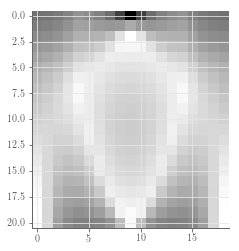

In [7]:
plt.imshow(scores)
plt.gray()
plt.show()

In [8]:
# get sorted indices
sorted_indices = np.array(np.unravel_index(np.argsort(scores, axis=None), scores.shape)).T
print(sorted_indices)


[[ 0  9]
 [ 0 10]
 [ 0  8]
 [ 0 11]
 [ 0  7]
 [ 0  0]
 [ 0 18]
 [ 0  1]
 [ 0 17]
 [ 0  2]
 [ 0 16]
 [ 1  0]
 [ 1 18]
 [ 1  1]
 [ 1 17]
 [20  5]
 [20 13]
 [ 0 12]
 [ 0  6]
 [20 14]
 [20  4]
 [ 0  3]
 [ 0 15]
 [20  6]
 [20 12]
 [ 1  2]
 [ 1 16]
 [ 2  0]
 [ 2 18]
 [20 15]
 [20  3]
 [ 0  5]
 [ 0 13]
 [ 2  1]
 [ 2 17]
 [19 14]
 [19  4]
 [ 1  3]
 [ 1 15]
 [19  5]
 [19 13]
 [ 0  4]
 [ 0 14]
 [20  7]
 [20 11]
 [ 2  2]
 [ 2 16]
 [ 3  0]
 [ 3 18]
 [19 15]
 [19  3]
 [ 1  7]
 [ 1 11]
 [ 1  8]
 [ 1 10]
 [ 1  6]
 [ 1 12]
 [ 3  1]
 [ 3 17]
 [18 14]
 [18  4]
 [19  6]
 [19 12]
 [ 1  5]
 [ 1 13]
 [20  2]
 [20 16]
 [ 2  3]
 [ 2 15]
 [18  3]
 [18 15]
 [ 1  4]
 [ 1 14]
 [ 3  2]
 [ 4  0]
 [ 3 16]
 [ 4 18]
 [18  5]
 [18 13]
 [19  2]
 [19 16]
 [ 4  1]
 [ 4 17]
 [17 14]
 [17  4]
 [ 1  9]
 [17  3]
 [17 15]
 [ 5  0]
 [18  2]
 [18 16]
 [ 5 18]
 [ 3  3]
 [ 3 15]
 [ 4  2]
 [ 2  5]
 [ 2 13]
 [ 4 16]
 [ 2  4]
 [ 2 14]
 [17 13]
 [17  5]
 [ 2  6]
 [ 2 12]
 [16  3]
 [16 15]
 [18  6]
 [18 12]
 [16 14]
 [16  4]
 [17  2]
 

In [9]:
# look at the top 10 scores

"""
print("Pitches: \n{0}".format(camera_pitches))
print("Yaws: \n{0}".format(camera_yaws))
for pitch_index, yaw_index in sorted_indices[-10:]:
    pitch, yaw = camera_pitches[pitch_index], camera_yaws[yaw_index]
    print("Score: {2:.4f} -- Pitch: {0}, Yaw: {1} (index {3}, {4})".format(pitch, yaw, scores[pitch_index, yaw_index], pitch_index, yaw_index))
    
    c = Camera(camera_position, pitch, yaw)
    c.set_resolution(25, 25)
    c.set_fov(*fov_deg)
    
    pixel_probabilities = c.get_pixel_probabilities_for_road(road)
    plt.imshow(np.flip(pixel_probabilities, 0))
    plt.gray()
    plt.show()
"""

'\nprint("Pitches: \n{0}".format(camera_pitches))\nprint("Yaws: \n{0}".format(camera_yaws))\nfor pitch_index, yaw_index in sorted_indices[-10:]:\n    pitch, yaw = camera_pitches[pitch_index], camera_yaws[yaw_index]\n    print("Score: {2:.4f} -- Pitch: {0}, Yaw: {1} (index {3}, {4})".format(pitch, yaw, scores[pitch_index, yaw_index], pitch_index, yaw_index))\n    \n    c = Camera(camera_position, pitch, yaw)\n    c.set_resolution(25, 25)\n    c.set_fov(*fov_deg)\n    \n    pixel_probabilities = c.get_pixel_probabilities_for_road(road)\n    plt.imshow(np.flip(pixel_probabilities, 0))\n    plt.gray()\n    plt.show()\n'

In [10]:
"""
pitch_index, yaw_index= 2, 9
pitch, yaw = camera_pitches[pitch_index], camera_yaws[yaw_index]
print("pitch, yaw: {0}, {1}, precomputed score: {2}".format(pitch, yaw, scores[pitch_index, yaw_index]))
c = Camera(camera_position, pitch, yaw)
c.set_resolution(25, 25)
c.set_fov(*fov_deg)
pixel_probabilities = c.get_pixel_probabilities_for_road(road)
error_bounds = error_radius_across_pixels(c)
target = (1.0/(1+error_bounds)) * pixel_probabilities
score = np.sum(target)
print("Score: {0}".format(score))
plt.imshow(np.flip(pixel_probabilities, 0))
plt.gray()
plt.show()
"""

'\npitch_index, yaw_index= 2, 9\npitch, yaw = camera_pitches[pitch_index], camera_yaws[yaw_index]\nprint("pitch, yaw: {0}, {1}, precomputed score: {2}".format(pitch, yaw, scores[pitch_index, yaw_index]))\nc = Camera(camera_position, pitch, yaw)\nc.set_resolution(25, 25)\nc.set_fov(*fov_deg)\npixel_probabilities = c.get_pixel_probabilities_for_road(road)\nerror_bounds = error_radius_across_pixels(c)\ntarget = (1.0/(1+error_bounds)) * pixel_probabilities\nscore = np.sum(target)\nprint("Score: {0}".format(score))\nplt.imshow(np.flip(pixel_probabilities, 0))\nplt.gray()\nplt.show()\n'

In [11]:
"""
pitch_index, yaw_index = 7, 14
pitch, yaw = camera_pitches[pitch_index], camera_yaws[yaw_index]
print("pitch, yaw: {0}, {1}, precomputed score: {2}".format(pitch, yaw, scores[pitch_index, yaw_index]))
c = Camera(camera_position, pitch, yaw)
c.set_resolution(100, 100)
c.set_fov(*fov_deg)
pixel_probabilities = c.get_pixel_probabilities_for_road(road)
print("Sum pixel probabilities: {0}".format(np.sum(pixel_probabilities)))
error_bounds = error_radius_across_pixels(c)
print("Sum error bounds: {0}".format(np.sum(error_bounds)))
target = (1.0/(1+error_bounds)) * pixel_probabilities
score = np.sum(target)
print("Score: {0}".format(score))
plt.imshow(np.flip(pixel_probabilities, 0))
plt.gray()
plt.show()
"""

'\npitch_index, yaw_index = 7, 14\npitch, yaw = camera_pitches[pitch_index], camera_yaws[yaw_index]\nprint("pitch, yaw: {0}, {1}, precomputed score: {2}".format(pitch, yaw, scores[pitch_index, yaw_index]))\nc = Camera(camera_position, pitch, yaw)\nc.set_resolution(100, 100)\nc.set_fov(*fov_deg)\npixel_probabilities = c.get_pixel_probabilities_for_road(road)\nprint("Sum pixel probabilities: {0}".format(np.sum(pixel_probabilities)))\nerror_bounds = error_radius_across_pixels(c)\nprint("Sum error bounds: {0}".format(np.sum(error_bounds)))\ntarget = (1.0/(1+error_bounds)) * pixel_probabilities\nscore = np.sum(target)\nprint("Score: {0}".format(score))\nplt.imshow(np.flip(pixel_probabilities, 0))\nplt.gray()\nplt.show()\n'

In [12]:
"""
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scores_flat = scores.ravel()
ps, ys = np.meshgrid(camera_pitches, camera_yaws)
ps_, ys_ = ps.ravel(), ys.ravel()
bottom = np.zeros_like(ps_)
width = ps[0, 1] - ps[0,0]
depth = ys[0,0] - ys[1,0]
print(ps_.shape, ys_.shape, scores.ravel().shape)
print(width, depth)
ax.bar3d(ps_, ys_, bottom, width, depth, scores.ravel(), shade=True)
plt.show()
"""

"\nfig = plt.figure()\nax = fig.add_subplot(111, projection='3d')\nscores_flat = scores.ravel()\nps, ys = np.meshgrid(camera_pitches, camera_yaws)\nps_, ys_ = ps.ravel(), ys.ravel()\nbottom = np.zeros_like(ps_)\nwidth = ps[0, 1] - ps[0,0]\ndepth = ys[0,0] - ys[1,0]\nprint(ps_.shape, ys_.shape, scores.ravel().shape)\nprint(width, depth)\nax.bar3d(ps_, ys_, bottom, width, depth, scores.ravel(), shade=True)\nplt.show()\n"

In [13]:
"""
c2 = Camera(camera_position, 55, 25)
c2.set_resolution(200,200)
pixel_probabilities = c2.get_pixel_probabilities_for_road(road)
pitch = 55
for y in camera_yaws:
    print(y)
    c = Camera(camera_position, pitch, y)
    c.set_resolution(50, 50)
    pixel_probabilities = c.get_pixel_probabilities_for_road(road)
    # flip the y axis for displaying as an image...
    
    plt.imshow(np.flip(pixel_probabilities, 0))
    plt.gray()
    plt.show()
"""

'\nc2 = Camera(camera_position, 55, 25)\nc2.set_resolution(200,200)\npixel_probabilities = c2.get_pixel_probabilities_for_road(road)\npitch = 55\nfor y in camera_yaws:\n    print(y)\n    c = Camera(camera_position, pitch, y)\n    c.set_resolution(50, 50)\n    pixel_probabilities = c.get_pixel_probabilities_for_road(road)\n    # flip the y axis for displaying as an image...\n    \n    plt.imshow(np.flip(pixel_probabilities, 0))\n    plt.gray()\n    plt.show()\n'

## Take into account Curvature
how to handle edge of roads? usually have an occlusion... 
* add a cylinder at the position the camera is located! => raytracer will intersect this

In [14]:
def plot_vector(axis, vec_start, vec_end):
    x,y,z =vec_start
    u,v,w = vec_end - vec_start
    axis.quiver(x,y,z,u,v,w)
def plot_points(axis, points):
    if points.shape[0] == 0:
        return
    axis.scatter(points[:, 0], points[:, 1], points[:, 2])

In [ ]:
curvatures = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3]
# curvatures = [0.1]
curvature_score_maps = []
# separate cell => abort and can save partial results

---- Curvature: 0.001 ----
Cylinder radius: 997.0
Road radius: 1000.0
Processing: pitch -- 31.0, yaw -- 180.0
Score: 13.3516685383
Processing: pitch -- 34.0, yaw -- 180.0
Score: 14.4826218867
Processing: pitch -- 37.0, yaw -- 180.0
Score: 15.5331570662
Processing: pitch -- 40.0, yaw -- 180.0
Score: 16.5007316145
Processing: pitch -- 43.0, yaw -- 180.0
Score: 17.3784592948
Processing: pitch -- 46.0, yaw -- 180.0
Score: 18.1690269357
Processing: pitch -- 49.0, yaw -- 180.0
Score: 18.882696525
Processing: pitch -- 52.0, yaw -- 180.0
Score: 19.5340353542
Processing: pitch -- 55.0, yaw -- 180.0
Score: 20.1390644864
Processing: pitch -- 58.0, yaw -- 180.0
Score: 20.7134535898
Processing: pitch -- 61.0, yaw -- 180.0
Score: 21.2714784913
Processing: pitch -- 64.0, yaw -- 180.0
Score: 21.8252185015
Processing: pitch -- 67.0, yaw -- 180.0
Score: 22.3835072691
Processing: pitch -- 70.0, yaw -- 180.0
Score: 22.9502230645
Processing: pitch -- 73.0, yaw -- 180.0
Score: 23.521821063
Processing: pitch

Score: 22.9745288881
Processing: pitch -- 55.0, yaw -- 240.0
Score: 22.6983729513
Processing: pitch -- 58.0, yaw -- 240.0
Score: 22.5501649011
Processing: pitch -- 61.0, yaw -- 240.0
Score: 22.5266181472
Processing: pitch -- 64.0, yaw -- 240.0
Score: 22.6272218393
Processing: pitch -- 67.0, yaw -- 240.0
Score: 22.8542134256
Processing: pitch -- 70.0, yaw -- 240.0
Score: 23.2126697269
Processing: pitch -- 73.0, yaw -- 240.0
Score: 23.6912036045
Processing: pitch -- 76.0, yaw -- 240.0
Score: 23.5954594443
Processing: pitch -- 79.0, yaw -- 240.0
Score: 22.1811144822
Processing: pitch -- 82.0, yaw -- 240.0
Score: 20.428324114
Processing: pitch -- 85.0, yaw -- 240.0
Score: 18.5104812999
Processing: pitch -- 88.0, yaw -- 240.0
Score: 16.4070122552
Processing: pitch -- 91.0, yaw -- 240.0
Score: 14.0905368057
Processing: pitch -- 31.0, yaw -- 250.0
Score: 11.8504997995
Processing: pitch -- 34.0, yaw -- 250.0
Score: 15.7435370122
Processing: pitch -- 37.0, yaw -- 250.0
Score: 19.5170244602
Proc

Score: 22.1811144822
Processing: pitch -- 82.0, yaw -- 300.0
Score: 20.428324114
Processing: pitch -- 85.0, yaw -- 300.0
Score: 18.5104812999
Processing: pitch -- 88.0, yaw -- 300.0
Score: 16.4070122552
Processing: pitch -- 91.0, yaw -- 300.0
Score: 14.0905368057
Processing: pitch -- 31.0, yaw -- 310.0
Score: 14.8332119931
Processing: pitch -- 34.0, yaw -- 310.0
Score: 16.5423598506
Processing: pitch -- 37.0, yaw -- 310.0
Score: 18.2687882659
Processing: pitch -- 40.0, yaw -- 310.0
Score: 20.0169208091
Processing: pitch -- 43.0, yaw -- 310.0
Score: 21.7814415256
Processing: pitch -- 46.0, yaw -- 310.0
Score: 23.3561828922
Processing: pitch -- 49.0, yaw -- 310.0
Score: 24.0607964159
Processing: pitch -- 52.0, yaw -- 310.0
Score: 23.9970912387
Processing: pitch -- 55.0, yaw -- 310.0
Score: 23.8586355161
Processing: pitch -- 58.0, yaw -- 310.0
Score: 23.8394258547
Processing: pitch -- 61.0, yaw -- 310.0
Score: 23.9514683561
Processing: pitch -- 64.0, yaw -- 310.0
Score: 24.1807648414
Proc

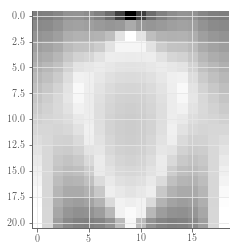

---- Curvature: 0.005 ----
Cylinder radius: 197.0
Road radius: 200.0
Processing: pitch -- 31.0, yaw -- 180.0
Score: 13.3049211229
Processing: pitch -- 34.0, yaw -- 180.0
Score: 14.4968277131
Processing: pitch -- 37.0, yaw -- 180.0
Score: 15.5406805118
Processing: pitch -- 40.0, yaw -- 180.0
Score: 16.4981305861
Processing: pitch -- 43.0, yaw -- 180.0
Score: 17.3689614101
Processing: pitch -- 46.0, yaw -- 180.0
Score: 18.1562121439
Processing: pitch -- 49.0, yaw -- 180.0
Score: 18.8698134981
Processing: pitch -- 52.0, yaw -- 180.0
Score: 19.5234454134
Processing: pitch -- 55.0, yaw -- 180.0
Score: 20.1320144212
Processing: pitch -- 58.0, yaw -- 180.0
Score: 20.7100616264
Processing: pitch -- 61.0, yaw -- 180.0
Score: 21.2708168009
Processing: pitch -- 64.0, yaw -- 180.0
Score: 21.8254591713
Processing: pitch -- 67.0, yaw -- 180.0
Score: 22.382148317
Processing: pitch -- 70.0, yaw -- 180.0
Score: 22.9444751101
Processing: pitch -- 73.0, yaw -- 180.0
Score: 23.5092599914
Processing: pitch

In [ ]:
for curvature in curvatures:
    print("---- Curvature: {0} ----".format(curvature))
    camera_height = 6.0
#     resolution = (200, 200) # use same resolution for all
    fov_deg = (60.0, 60.0)
    yaw_range = 90 # degrees +- from center yaw position

    length = 2*np.pi/curvature # 1 full revolution

    path = Path()
    path.add_segment(curvature, length)
    road = Road(path=path, probability_distribution=road_prob_dist, width=3.0, side_offset=1.5)

    # place camera halfway along road
    allowed_positions_orientations = road.get_allowed_camera_positions_at_distance(length/2.0)
    lhs_pos, lhs_direction = allowed_positions_orientations[0]
    rhs_pos, rhs_direction = allowed_positions_orientations[1]

    #TODO figure out which one is LHS versus RHS for positive curvature...
    # ====> the first element (lhs here) is OUT ie. away from center of curvature
    # ====> LHS is good for first tests of outside
    
    camera_position = lhs_pos + np.array([0.0, 0.0, camera_height])
    camera_pitches = np.arange(31.0, 92.0, 3)

    # convert lhs_direction into a yaw facing the road perpendicularly
    center_yaw_rad = np.arccos(np.dot(np.array([1.0,0,0]), h.normalize(lhs_direction)))
    center_yaw_deg = np.rad2deg(center_yaw_rad) + 180 # TODO figure out automatically if the +180 is required
    camera_yaws = np.arange(center_yaw_deg - yaw_range, center_yaw_deg + yaw_range + 10, 10.0)
    
    # cylinder charactistics
    road_pt = road.path.get_point_at(length/2.0)
    road_normal = road.path.get_normal_at(length/2.0)
    road_radius = np.abs(1.0/road.path.get_curvature_at(length/2.0))
    cylinder_radius = np.abs(1.0/road.path.get_curvature_at(length/2.0)) 
    cylinder_radius -= road.halfwidth 
    cylinder_radius -= road.side_offset
    cylinder_center = road_pt + road_normal * road_radius
    cylinder_direction = np.array([0.0, 0.0, 1.0])
    
    x_unit, y_unit = np.array([1.0,0,0]), np.array([0.0, 1.0, 0.0])
    
    path_points = []
    for d in np.arange(0, length, 0.5):
        path_points.append(road.path.get_point_at(d))
    path_points = np.array(path_points)
    
    
    print("Cylinder radius: {0}".format(cylinder_radius))
    print("Road radius: {0}".format(1/road.path.get_curvature_at(length/2.0)))

    scores = np.zeros(shape=(camera_pitches.shape[0], camera_yaws.shape[0]))
    for j, yaw in enumerate(camera_yaws):
        for i, pitch in enumerate(camera_pitches):
            print("Processing: pitch -- {0}, yaw -- {1}".format(pitch, yaw))
            name = "pitch_{0}_yaw_{1}".format(pitch, yaw)
            camera = Camera(camera_position, pitch, yaw)
            camera.set_resolution(*resolution)
            camera.set_fov(*fov_deg)
            # set edge boundary for visual obstruction
            camera.attach_cylinder(cylinder_center, cylinder_direction, cylinder_radius)

            pixel_probabilities = camera.get_pixel_probabilities_for_road(road)

            # didn't want any pyplot stuff running
            # in case of leaking memory from open figures that I don't quite understand

#             plt.imshow(np.flip(pixel_probabilities, 0))
#             plt.gray()
#             plt.show()
            
#             fig = plt.figure()
#             ax = fig.add_subplot(111, projection='3d')
#             ax.view_init(elev=10., azim=0.0)
#             plot_vector(ax, camera.position, camera.position+camera.orientation_vector)
#             corners = camera.get_corners()
#             corners = np.array([x for x in corners if x is not None])
#             plot_points(ax, corners)
#             plot_points(ax, path_points)
#             plot_vector(ax, cylinder_center, cylinder_center + cylinder_direction)
#             plot_vector(ax, cylinder_center, cylinder_center+x_unit*cylinder_radius)
#             plot_vector(ax, cylinder_center, cylinder_center+y_unit*cylinder_radius)
#             plt.show()
            



            # calculate error radius at each pixel
            error_bounds = error_radius_across_pixels(camera)
    #         plt.imshow(error_bounds)
    #         plt.gray()
    #         plt.imsave(save_dir + name + "_error_bounds.png")

            target = (1.0/(1+error_bounds)) * pixel_probabilities
    #         plt.imshow(product)
    #         plt.gray()
    #         plt.imsave(save_dir + name + "_product.png")
            # take the sum => now have an expected value!

            score = np.sum(target)
            print("Score: {0}".format(score))
            scores[i, j] = score
    plt.imshow(scores)
    plt.gray()
    plt.show()
    curvature_score_maps.append(scores)

In [ ]:
curvature_score_maps = np.array(curvature_score_maps)
np.save("curved_roads_{0}x{1}_6m-4_two_stddev.npy".format(*resolution), scores)


In [ ]:
for score_map in curvature_score_maps:
    plt.imshow(score_map)
    plt.gray()
    plt.show()

In [ ]:
# get sorted indices
sorted_indices = np.array(np.unravel_index(np.argsort(scores, axis=None), scores.shape)).T
print(sorted_indices)